# **Reconnaissance vocale des chiffres de 0-9**

In [4]:
import librosa
import noisereduce as nr
import numpy as np
import pandas as pd
import librosa.display
import os
import IPython.display as ipd
from matplotlib.colors import Normalize
import random
import joblib
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.io.wavfile import write
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import keras
import seaborn as sns
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

## Chargement et prétraitement des audios
Nous devons comprendre l'étiquetage de notre jeu de données DATA. Chaque fichier est etiqueté de telle sorte que le premier chiffre représente le chiffre prononcé.

In [5]:
def premier_chiffre(chaine):
    for caractere in chaine:
        if caractere.isdigit():
            return int(caractere)
    return None

In [6]:
#directory représente le dossier ou se trouve les données
directory = 'dataFIN/'
audio = []
label = []
all_SR=[]
liste_audio = os.listdir(directory)
random.shuffle(liste_audio)
for i in range(len(liste_audio)):
    aud, sr = librosa.load(directory+liste_audio[i], sr=None)
    audio.append(aud)
    all_SR.append(sr)
    label.append(premier_chiffre(liste_audio[i]))


In [7]:
# Fonction pour afficher l'onde sonore
def afficher_onde_sonore(audio, label):
  plt.figure(figsize=(18, 9))
  for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(audio[i])
    plt.title(f"Chiffre {label[i]}")
    plt.xlabel("Temps")
    plt.ylabel("Amplitude")
  plt.subplots_adjust(wspace=0.2, hspace=0.7)
  plt.show()

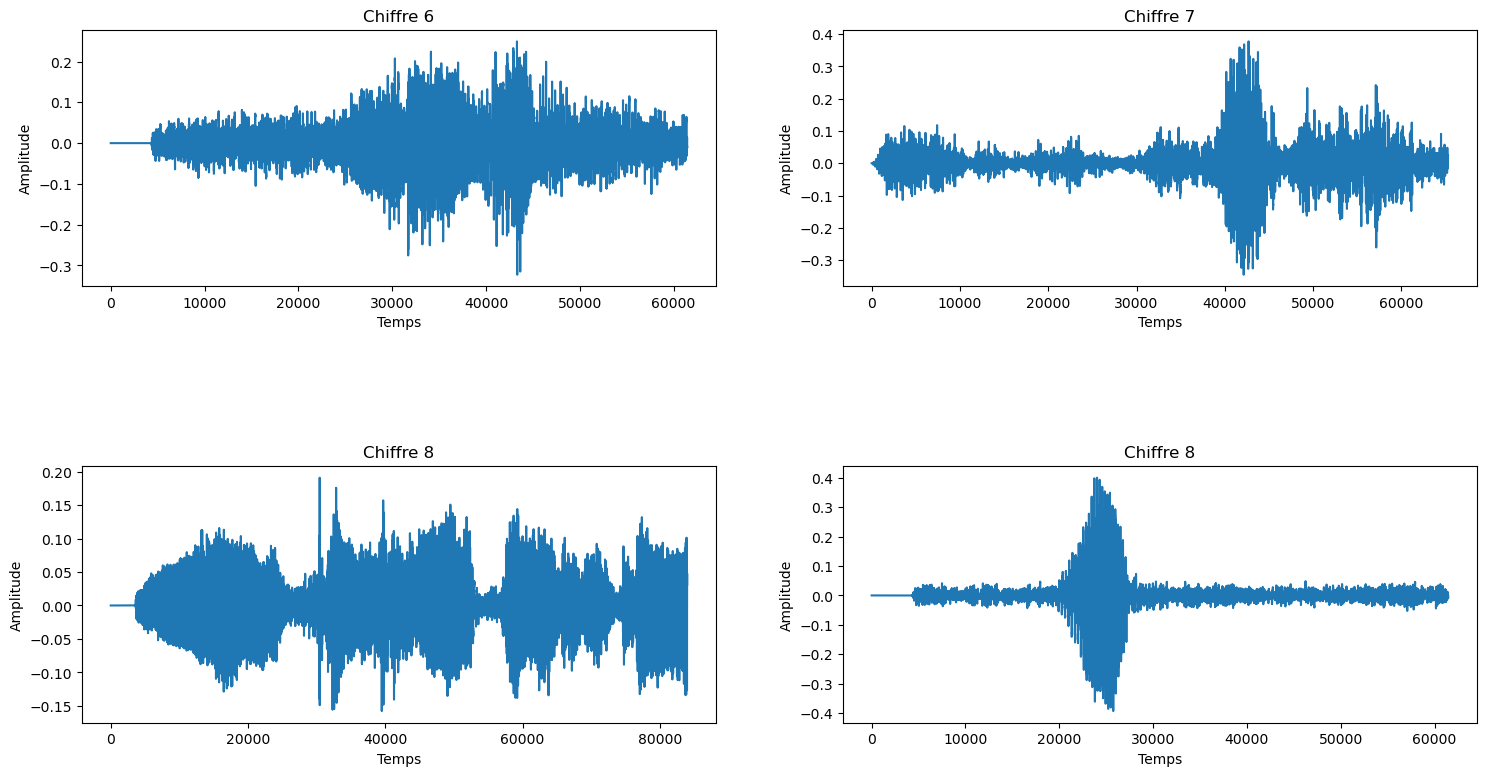

In [8]:
afficher_onde_sonore(audio, label)

In [9]:
ipd.Audio(directory+liste_audio[0])

In [10]:
ipd.Audio(directory+liste_audio[1])

## Traitement des audios 

Nous mettrons en place un ensemble de traitement dont les avantages sont : l'uniformité des niveaux sonores, l'amélioration de la qualité des caractéristiques, la stabilité du modèle.</br>
Ceci va consister à:
- Retirer les moments de silence dans les audios pour ne garder que les parties où le locuteur prononce le chiffre
- Supprimer les bruits dans l'audio
- Normaliser l'audio c-a-d ramener les signaux entres -1 et 1

La suppression des bruits se fera avec la bibliothèque noicereduce pour plusieurs raisons:
- Librosa ne propose pas de fonctionnalités avancées de réduction de bruit par défaut.
- Librosa est plus orientée vers l'analyse et la transformation que vers le prétraitement audio comme la réduction de bruit.
- Noicereduce est spécialisée dans la réduction de bruit, offrant des algorithmes performants pour cette tâche.
- Elle propose des fonctionnalités simples et efficaces pour le prétraitement audio

In [11]:
def traitement_audio(audios):
    clean_audio = []
    for i in range(len(audio)):
        # Extraction du bruit
        noise_profile = audios[i][:all_SR[i]]  # En supponsant que les premières instants sont du bruits
        # Appliquer la reduction du bruit en utilisant noise_profile
        reduced_noise = nr.reduce_noise(y=audios[i], sr=all_SR[i], y_noise=noise_profile)
        #Retirer les moments de silence en debut et à la fin de l'audio
        audio_trim,_=librosa.effects.trim(reduced_noise, top_db=10)
        #Normaliser l'audio c-a-d ramener les signaux entres -1 et 1
        clean_audio.append(librosa.util.normalize(audio_trim))
        print('\r' + f' Processed {i+1}/{2100} audio samples',end=' ')
    return clean_audio

In [12]:
clean_audio = traitement_audio(audio)

 Processed 2100/2100 audio samples 

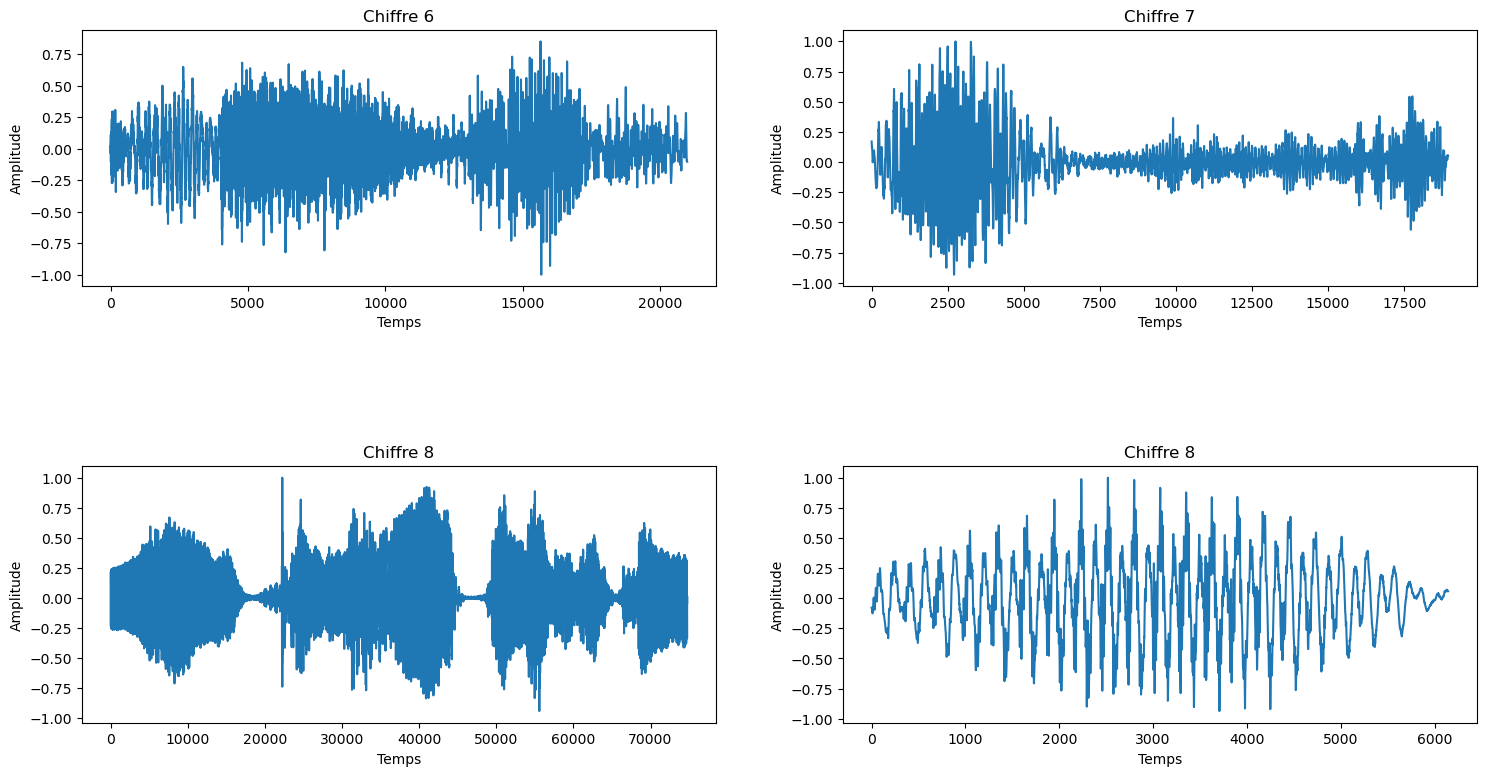

In [13]:
afficher_onde_sonore(clean_audio, label)

## Extraction des caractéristiques des audios avec MFCC

#**Extraire les fonctionnalités d'un fichier audio | MFCC |**
Les MFCC (Coefficients Cepstraux Mel-Fréquence) sont des coefficients qui représentent les caractéristiques spectrales du signal audio.. Il s'agit d'une technique d'extraction de caractéristiques largement utilisée dans le domaine du traitement du signal audio, en particulier pour des tâches telles que l'analyse, la reconnaissance et la classification de la parole et de la musique. Les MFCC sont dérivés des caractéristiques spectrales d’un signal audio et sont conçus pour imiter la perception du son par le système auditif humain.

In [15]:
def extraire_mfcc(audios):
    mfc_coefficients = []
    for i in range(len(audios)):
        if isinstance(audios[i], np.ndarray):
            mfccs = librosa.feature.mfcc(y=audios[i], sr=all_SR[i], n_mfcc=40)
            mfc_coefficients.append(mfccs)
            print('\r' + f' Processed {i+1}/{2100} audio samples',end=' ')
        else:
            raise ValueError("Chaque segment audio doit être un tableau numpy")
    return mfc_coefficients

In [16]:
features = extraire_mfcc(clean_audio)

 Processed 2100/2100 audio samples 

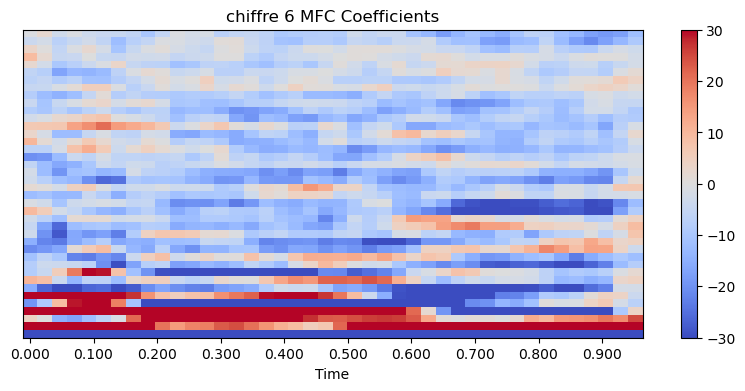

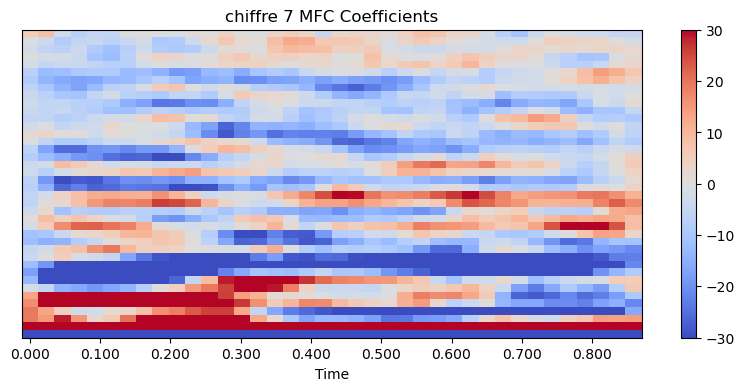

In [17]:
for i in range (2):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(features[i], x_axis='time',norm=Normalize(vmin=-30,vmax=30))
    plt.colorbar()
    plt.title(f'chiffre {label[i]} MFC Coefficients')


<b>Les MFCC positifs correspondent aux régions de basse fréquence du cepstrum, et les MFCC négatifs aux hautes fréquences.</br>

## OBSERVATIONS ET LABELS

In [18]:
# X représente nos caractéristiques et y les labels ils sont convertis en tableau numpy
X = []
for mfcc in features:
    X.append(np.mean(mfcc, axis=1))
    
X = np.array(X)
y = np.array(label)

In [19]:
######## Affichons sous forme de dataframe pour une visualisation plus claire de notre jeu de données ###############
print(f'\nNombre de fichier audio: {X.shape[0]}')
print(f'Nombre de caratéristique extrait par audio: {X.shape[1]}')
features_df = pd.DataFrame(X, index = liste_audio) # make it pretty for display
features_df1 = features_df
features_df1['Label'] = y
features_df1


Nombre de fichier audio: 2100
Nombre de caratéristique extrait par audio: 40


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,Label
6_2024-05-31_111639302.wav,-156.177460,123.161865,17.097311,20.289236,-30.155718,4.205307,-23.591496,1.536095,-13.480488,-13.589818,...,-7.776281,-0.256942,-3.526889,-3.967333,-3.955306,-1.794829,-3.376396,-7.927204,-7.906879,6
7_2024-05-31_102710823.wav,-286.491699,176.038773,6.854404,-18.303890,17.856066,11.786647,0.014497,-3.505389,-36.085255,-57.592209,...,-5.601337,-7.007240,-10.144652,-5.484778,0.247735,0.068585,-0.563651,0.778420,0.004158,7
8-URecorder_20240615_053451.wav,-281.531158,125.787857,-38.529484,-23.607296,-8.967630,-19.532738,-17.067223,-1.309320,-13.071106,-5.288087,...,0.883309,0.300225,-6.091965,-7.291195,-1.994500,-2.939979,-5.912045,-2.359707,2.102953,8
8_2024-05-31_103018235.wav,-164.318832,114.825157,-34.481407,60.371094,31.784044,38.052029,-30.308327,-9.902999,-3.910954,-7.974281,...,-7.920300,-5.470340,-0.181667,-8.228784,-11.272846,-9.417274,-6.018802,-15.332894,-6.783016,8
0-URecorder_20240629_071322.wav,-274.871307,175.779831,52.930927,54.499599,11.660742,0.392663,-14.893742,-10.599595,-14.820858,-1.575429,...,-4.033986,-2.930803,-2.536653,-3.896384,2.390818,-1.976326,-9.899464,-4.925996,-3.678815,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6J2_2024-05-31_102229805.wav,-227.527039,210.792130,-15.608171,23.326727,69.862556,17.751017,-20.839365,-15.059001,0.289661,-2.623385,...,-6.914026,-3.732365,-2.927365,-6.685177,-7.957251,-1.871589,-0.664689,-5.355844,-2.801341,6
1_2024-05-31_120740180.wav,-134.253082,149.787659,-23.495804,-27.034231,-29.596886,37.120644,-36.193058,-7.665606,-23.508459,-20.273708,...,-2.352619,-8.284538,-2.323701,-0.818768,-3.807185,-3.721560,-2.926791,-3.824593,-5.962821,1
3_2024-05-31_115028893.wav,-149.462570,133.195801,-15.855201,4.577511,-50.874088,-9.051344,-53.435780,10.136009,-2.985906,-13.270025,...,-25.334534,1.541449,-10.990279,4.076682,8.687191,17.721081,15.818343,13.831361,10.460741,3
6K3_2024-05-30_125236960.wav,-284.899475,171.158371,-12.054204,86.330139,28.784197,-28.805073,21.882771,-19.186810,-26.999397,11.417162,...,14.848104,3.087997,7.822964,8.338994,-5.216602,4.350480,3.462830,-7.112994,1.744614,6


Maintenant observons la repartitions de chaque chiffre dans notre dataset

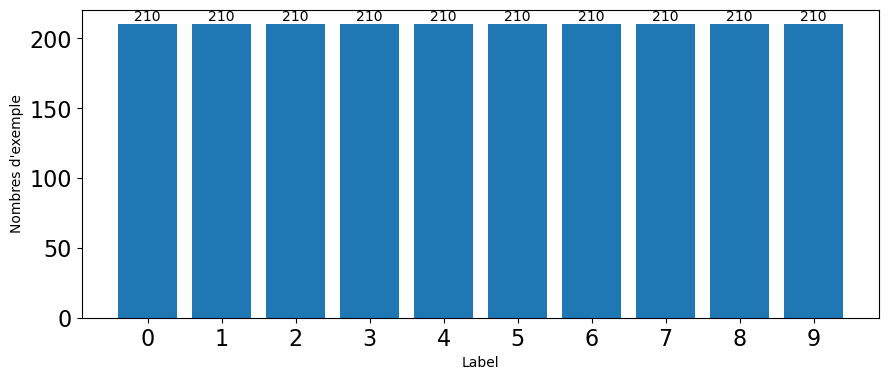

In [20]:
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)

chiffre_liste, count = np.unique(label, return_counts=True)
plt.bar(x=range(10), height=count)
plt.xticks(ticks=range(10), labels = [chiffre for chiffre in chiffre_liste],fontsize=10)
for i, v in enumerate(count):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
plt.xlabel('Label')
plt.tick_params(labelsize=16)
plt.ylabel("Nombres d'exemple")
plt.show()

## Feature scaling
Pour entraîner correctement la plupart des modèles d'apprentissage automatique sur la plupart des ensembles de données, nous devons d'abord mettre à l'échelle nos caractéristiques. C'est crucial pour les modèles qui calculent les distances entre les données, et particulièrement important pour les réseaux de neurones

Vérifions les propriétés de nos caractéristiques :

In [21]:
def print_features(df):
    mfcc_min = df.min().min()
    mfcc_max = df.max().max()
    # En utilisant la methode stack, permet de rassembler tout notre dataframe en unse série afin d'éviter de calculer la moyenne de la moyenne ou std de std
    mfcc_mean = df.stack().mean()
    mfcc_stdev = df.stack().std()
    print(f'\n40 MFCC features:             \
    min = {mfcc_min:.3f},\
    max = {mfcc_max:.3f},\
    mean = {mfcc_mean:.3f},\
    variance = {mfcc_stdev:.3f}')

In [22]:
print_features(features_df)


40 MFCC features:                 min = -470.683,    max = 293.810,    mean = -5.315,    variance = 48.685


Nous aurons certainement besoin de mettre à l'échelle nos caractéristiques de mfcc. La mise à l'échelle Min-Max de sklearn transforme chaque caractéristique pour qu'elle se trouve dans un intervalle borné que nous spécifions, elle est particulièrement utile lorsque nous savons que nos mfcc suit une echelle de valeur.

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (-1,1))
features_minmax = X
features_minmax = scaler.fit_transform(features_minmax)

In [24]:
print('MinMax Scaling:\n')
features_minmax_df = pd.DataFrame(features_minmax)
print_features(features_minmax_df)
features_minmax_df

MinMax Scaling:


40 MFCC features:                 min = -1.000,    max = 1.000,    mean = -0.107,    variance = 0.311


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.381608,0.102096,0.187523,-0.143799,-0.623458,0.107674,-0.146838,0.175000,0.024234,-0.158760,...,-0.372795,-0.326929,-0.263836,-0.349447,-0.396119,-0.395624,-0.230235,-0.304694,-0.566441,-0.472036
1,-0.190856,0.380320,0.101707,-0.461463,-0.149982,0.185567,0.218170,0.074965,-0.427421,-1.000000,...,-0.440693,-0.261072,-0.494642,-0.602037,-0.445246,-0.259728,-0.158203,-0.190904,-0.238314,-0.198239
2,-0.169064,0.115914,-0.278525,-0.505116,-0.414508,-0.136218,-0.045957,0.118540,0.032413,-0.000047,...,-0.223395,-0.064721,-0.244785,-0.447352,-0.503730,-0.332226,-0.274502,-0.407273,-0.356595,-0.125601
3,0.345844,0.058231,-0.244610,0.186120,-0.012629,0.455425,-0.250697,-0.051979,0.215438,-0.051402,...,-0.242520,-0.331289,-0.442092,-0.221765,-0.534084,-0.632219,-0.524888,-0.411592,-0.845571,-0.433140
4,-0.139808,0.378957,0.487741,0.137791,-0.211078,0.068502,-0.012349,-0.065801,-0.002548,0.070932,...,-0.017900,-0.213614,-0.355260,-0.311651,-0.393822,-0.190437,-0.237251,-0.568584,-0.453321,-0.325705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,0.068173,0.563182,-0.086488,-0.118797,0.362889,0.246846,-0.104283,-0.154286,0.299368,0.050897,...,-0.271794,-0.300820,-0.382667,-0.326564,-0.484110,-0.525017,-0.233202,-0.194992,-0.469523,-0.295336
2096,0.477921,0.242194,-0.152571,-0.533324,-0.617947,0.445856,-0.341690,-0.007584,-0.176130,-0.286543,...,-0.266440,-0.162703,-0.538315,-0.303523,-0.294183,-0.390835,-0.304715,-0.286505,-0.411808,-0.404753
2097,0.411106,0.154892,-0.088557,-0.273124,-0.827776,-0.028529,-0.608306,0.345643,0.233921,-0.152646,...,-0.327545,-0.858583,-0.202345,-0.634313,-0.135691,0.013142,0.524172,0.471828,0.253668,0.163657
2098,-0.183861,0.354640,-0.056712,0.399791,-0.042212,-0.231484,0.556309,-0.236192,-0.245881,0.319325,...,-0.137056,0.358126,-0.149466,0.083759,0.002302,-0.436405,0.007318,-0.028013,-0.535752,-0.138003


# Conception de notre modèle de PMC

Division des données en Train-Valid-Test

In [25]:
# Diviser les données en ensembles d'entraînement et de test

X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.36, random_state=42)

#Diviser les données de test en ensemble de test et de validation
X_valid, X_test, y_valid, y_test= train_test_split(X_tmp, y_tmp, test_size=0.2/0.36, random_state=42)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(1344, 40)
(336, 40)
(420, 40)


**One hot Encoding**

In [26]:
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

In [27]:
for i in range(3):
    print(y_train[i])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


# **Conception du modèle**

In [28]:
# Instantiate the model.
model = tf.keras.Sequential()

# Build the model.
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(10,  activation="softmax"))

# Display the model summary.
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,050 (90.04 KB)

 Trainable params: 23,050 (90.04 KB)

 Non-trainable params: 0 (0.00 B)

### Compilation du modèle

In [29]:
model.compile(optimizer=keras.optimizers.Adam(0.002),
              loss="categorical_crossentropy",#Car il s'agit d'un problème de classification multiclasse
              metrics=["accuracy"])

### Entrainement du modèle

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
training_results = model.fit(X_train,
                             y_train,
                             epochs=30,
                             batch_size=15,
                             validation_data=(X_valid, y_valid),
                             callbacks=[early_stopping]);

Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2009 - loss: 11.5656 - val_accuracy: 0.3780 - val_loss: 3.0888
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3656 - loss: 2.7902 - val_accuracy: 0.3571 - val_loss: 2.8622
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5115 - loss: 1.8082 - val_accuracy: 0.3988 - val_loss: 2.1634
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5423 - loss: 1.5570 - val_accuracy: 0.5327 - val_loss: 1.8531
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5992 - loss: 1.2481 - val_accuracy: 0.5089 - val_loss: 1.6832
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6242 - loss: 1.1431 - val_accuracy: 0.4643 - val_loss: 2.3349
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6350 - loss: 1.1429 - val_accuracy: 0.5089 - val_loss: 2.0655
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6443 - loss: 1.1556 - val_accuracy: 0.5536 - val_loss

In [31]:
#Visualisation des résultats de l'entrainement
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, 50])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

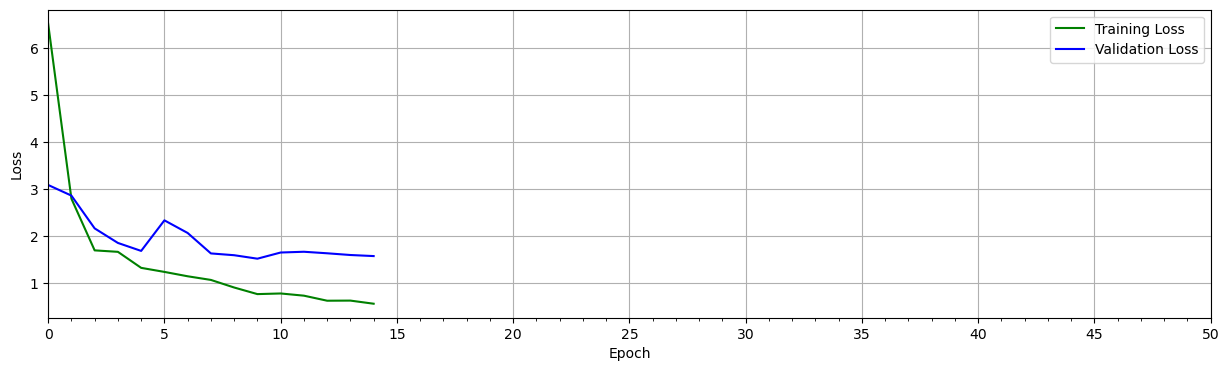

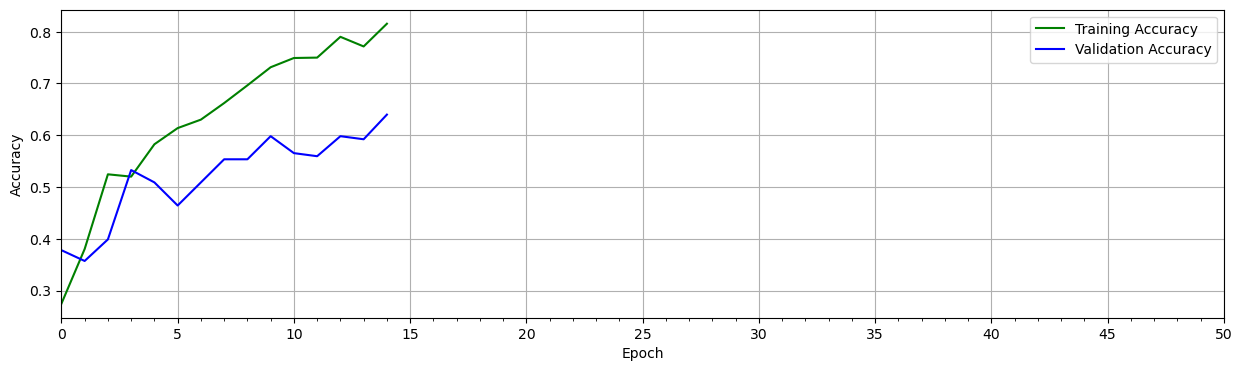

In [32]:
#Visualisation de la Loss et de l'Accuracy
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]

plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In [33]:
print(f"Précision avec les données d'entrainement: {(train_acc[-1])*100:.2f}%\nPrécision avec les données de Validation : {(valid_acc[-1])*100:.2f}%")

Précision avec les données d'entrainement: 81.55%
Précision avec les données de Validation : 63.99%


Faisons un test simple

In [34]:
predictions = model.predict(X_test)
index = 3 # up to 9999
print('Chiffre réelle: ',y_test[index])
print('\n');
print('Chiffre pédit pour chaque classe\n')
for i in range(10):
    print('chiffre:', i, ' probabilité: ', predictions[index][i])

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Chiffre réelle:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Chiffre pédit pour chaque classe

chiffre: 0  probabilité:  0.26069275
chiffre: 1  probabilité:  0.0030359218
chiffre: 2  probabilité:  0.23462011
chiffre: 3  probabilité:  9.824484e-06
chiffre: 4  probabilité:  9.847757e-06
chiffre: 5  probabilité:  0.0041825995
chiffre: 6  probabilité:  0.005663611
chiffre: 7  probabilité:  0.002746961
chiffre: 8  probabilité:  0.24766518
chiffre: 9  probabilité:  0.24137318


In [35]:
# generation de la prediction pour les données test
predictions = model.predict(X_test)

# pour chaque image des données test on selectionne la classe avec la plus grande probabilité
predicted_labels = [np.argmax(i) for i in predictions]

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [36]:
for i in range(10):
    print (f"Valeur vraie : {y_test[i]} = {np.argmax(y_test[i])} ---- Valeur prédite : {predicted_labels[i]}")

Valeur vraie : [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] = 8 ---- Valeur prédite : 2
Valeur vraie : [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] = 4 ---- Valeur prédite : 4
Valeur vraie : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] = 0 ---- Valeur prédite : 0
Valeur vraie : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] = 0 ---- Valeur prédite : 0
Valeur vraie : [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] = 2 ---- Valeur prédite : 2
Valeur vraie : [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] = 2 ---- Valeur prédite : 2
Valeur vraie : [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] = 6 ---- Valeur prédite : 7
Valeur vraie : [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] = 8 ---- Valeur prédite : 2
Valeur vraie : [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] = 9 ---- Valeur prédite : 4
Valeur vraie : [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] = 3 ---- Valeur prédite : 3


In [37]:
loss, accuracy = model.evaluate(X_test, y_test)
print (f"On obtient un accuracy de {(accuracy*100):.2f}% sur les données de test")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5848 - loss: 1.6375 
On obtient un accuracy de 60.00% sur les données de test


### Matrice de confusion

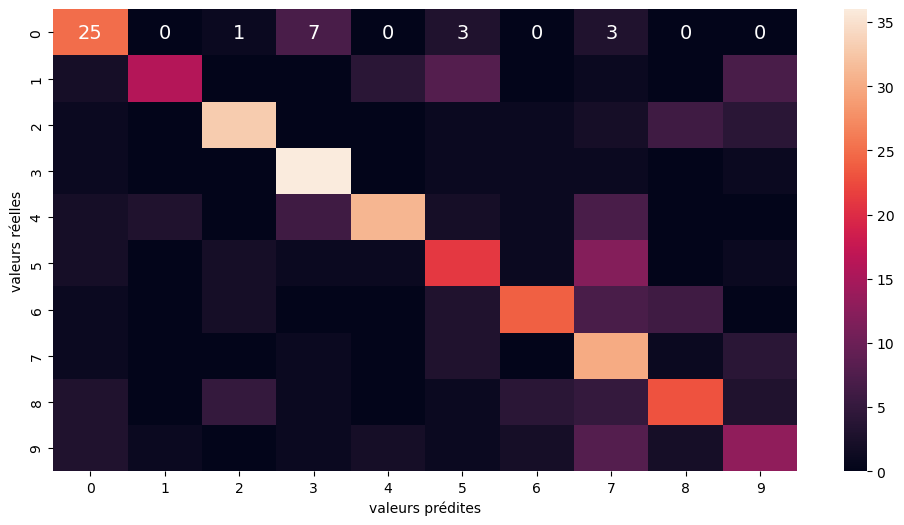

In [38]:
y_test_integer_labels = tf.argmax(y_test, axis=1)

# Generate a confusion matrix for the test dataset.
cm = tf.math.confusion_matrix(labels=y_test_integer_labels, predictions=predicted_labels)

# Plot the confusion matrix as a heatmap.
plt.figure(figsize=[12, 6])
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14})
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles')
plt.show()

In [39]:
sum_col=[]
sum_line=[]
df=[]
for index in range(cm.shape[0]):
  sum_col.append(np.sum(cm[:,index]))
  sum_line.append(np.sum(cm[index,:]))


for index in range(cm.shape[0]):
    res=dict()
    precision=cm[index,index]/sum_col[index]
    rappel=cm[index,index]/sum_line[index]
    f1score = 1/((1/2)*((1/precision)+(1/rappel)))
    res["Precision"]=float(precision)
    res["Rappel"]=float(rappel)
    res["F1Score"]=float(f1score)
    res["Classe"]=str(index)
    df.append(res)

In [40]:
df=pd.DataFrame(df)

In [41]:
df.set_index('Classe', inplace=True)

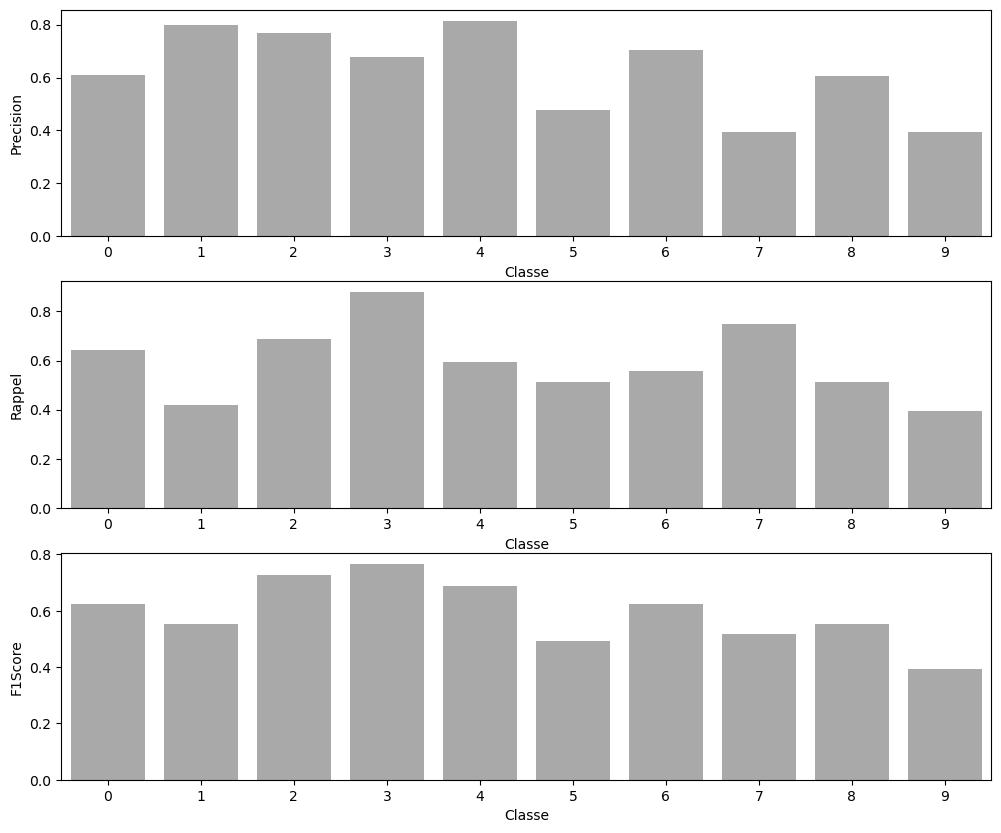

In [42]:
plt.figure(figsize=[12, 10])
plt.subplot(3,1,1)
sns.barplot(data=df,y='Precision', x=df.index,color='darkgrey')
plt.subplot(3,1,2)
sns.barplot(data=df,y='Rappel', x=df.index,color='darkgrey' )
plt.subplot(3,1,3)
sns.barplot(data=df,y='F1Score', x=df.index, color='darkgrey')
plt.savefig('métrique.png')

In [43]:
model.save('Projet_3721.keras')

In [44]:
test = tf.keras.models.load_model('Projet_3721.keras')